## Bayesian Optimisation Verification

In [20]:
# import relevant packages
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.metrics import mean_squared_error
# stop showing warning messages
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [2]:
# Setup data for training and evaluation
# generate timestamp from data sheet (time:0~5000s) 
X_ = np.linspace(0,5000, 5000)
df_time = X_
# import data sheet at 85 C (time:0~5000s) 
address = 'data/degradation.xlsx'
df = pd.read_excel(address,sheet_name = 'normal data',usecols = [3],names = None,nrows = 5000)
df_85 = df.values.tolist() 
df = pd.read_excel(address,sheet_name = 'smooth data',usecols = [3],names = None,nrows = 5000)
df_85s = df.values.tolist()
# Format date into numpy array format
y_normal = np.array(df_85).T 
y_normal = y_normal.reshape((5000))
x_normal = X_

In [21]:
# Plot function to show confidence bounds 
def plot(X_,y_normal,X,y_mean, y_cov,gp):
    plt.figure()
    plt.plot(X_, y_mean, 'k', lw=3, zorder=8)
    plt.scatter(X[:, 0], Y, c='r', s=50, zorder=10, edgecolors=(0, 0, 0))
    plt.scatter(X[:, 0], Y, c='r', s=50, zorder=10, edgecolors=(0, 0, 0))
    plt.tick_params(axis='y', colors = 'white')
    plt.tick_params(axis='x', colors = 'white')
    plt.ylabel('Lifetime',color = 'white')
    plt.xlabel('Time',color = 'white')
    plt.title("Initial: %s\nOptimum: %s\nLog marginal likelihood: %s" % 
                (kernel, gp.kernel_,gp.log_marginal_likelihood(gp.kernel_.theta)),
                color ='white')
    plt.tight_layout()
    plt.show()

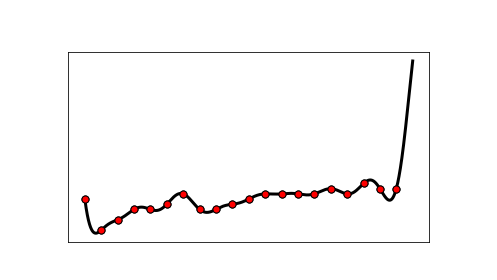

In [22]:
# gp prediction demo
# Prepare data used
NUM_OF_DATA_POINTS = 20
NOISE_LEVEL = 1e-16
X = np.arange(0,5000,int(5000/NUM_OF_DATA_POINTS))
X = X.reshape(X.size,1)
Y = y_normal[X]

# Kernel setting
kernel = 1.0 * RBF(length_scale=300) + WhiteKernel(noise_level=NOISE_LEVEL, noise_level_bounds=(1e-20, 1e+1))
gp = GaussianProcessRegressor(kernel=kernel,alpha=0.0).fit(X, Y)
y_mean, y_cov = gp.predict(X_[:, np.newaxis], return_cov=True)

plot(X_,y_normal,X,y_mean, y_cov,gp)




In [97]:
# Plot function to show performance of gp prediction
def plot_performance(list_NOISE_LEVEL,performance_parameter):
    plt.figure()
    plt.plot(list_NOISE_LEVEL, performance_parameter, c='blue', lw=2, zorder=3,)
    # plt.scatter(list_NOISE_LEVEL, performance_parameter, c='blue', s=2, zorder=3,)
    # plt.xscale('log')
    plt.tick_params(axis='y', colors = 'white')
    plt.tick_params(axis='x', colors = 'white')
    plt.ylabel('Performance parameter',color = 'white')
    plt.xlabel('Number of data points',color = 'white')
    # plt.title('Performance of gp',color ='white')
    plt.tight_layout()
    plt.show()

Number of data points used: 5


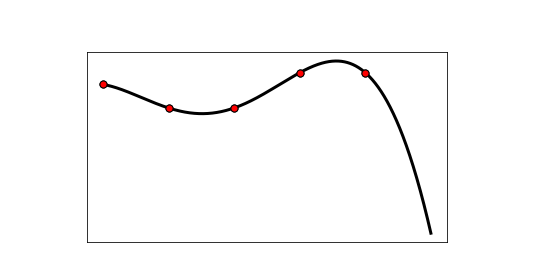

Number of data points used: 10


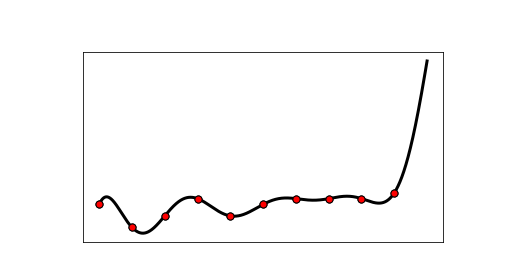

Number of data points used: 16


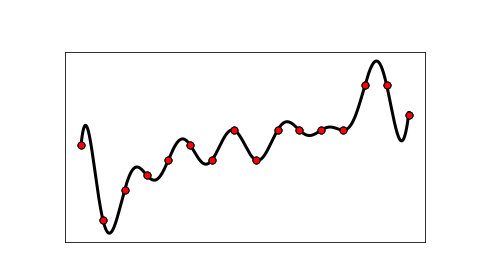

Number of data points used: 20


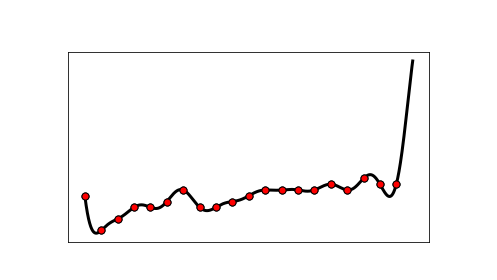

Number of data points used: 23


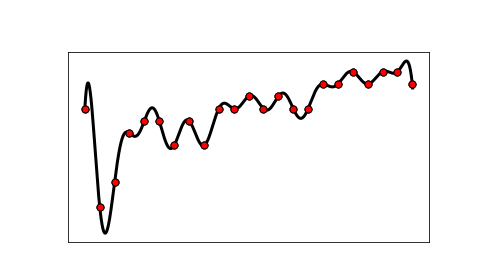

Number of data points used: 25


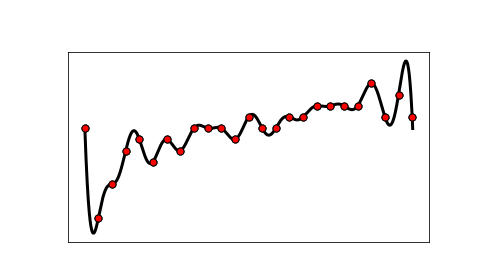

Number of data points used: 27


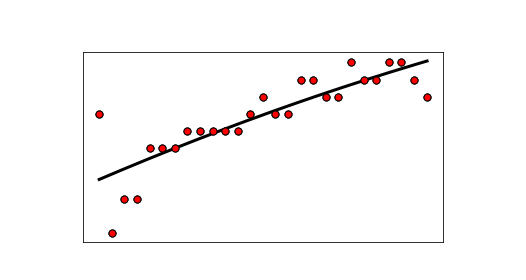

Number of data points used: 29


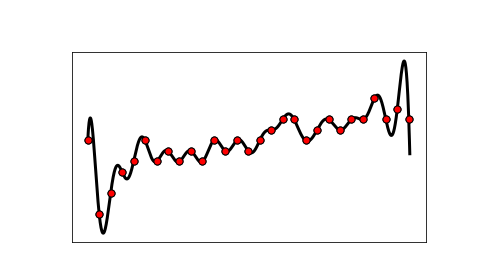

Number of data points used: 31


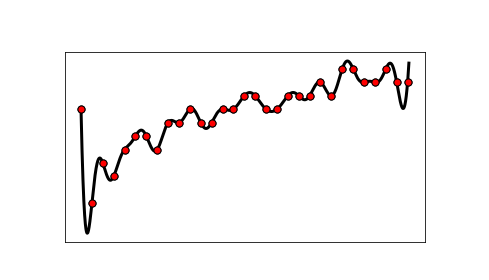

Number of data points used: 34


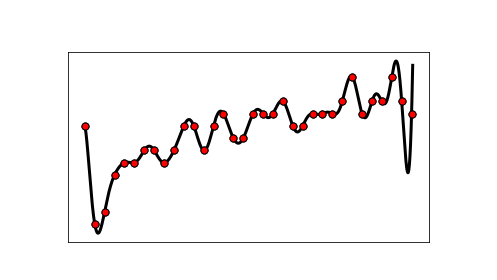

Number of data points used: 38


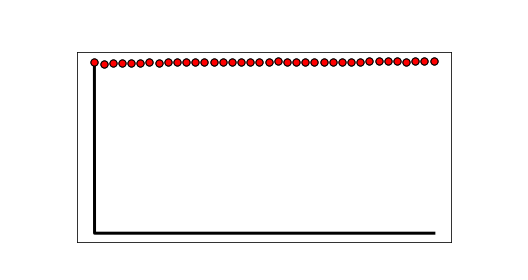

Number of data points used: 40


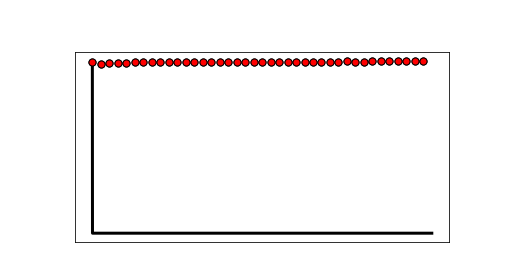

Number of data points used: 46


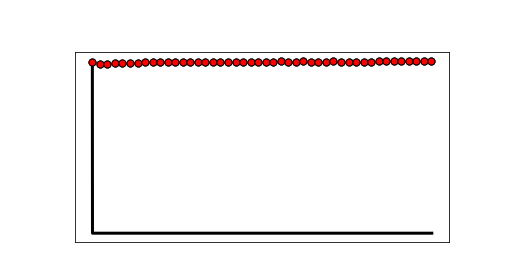

Number of data points used: 50


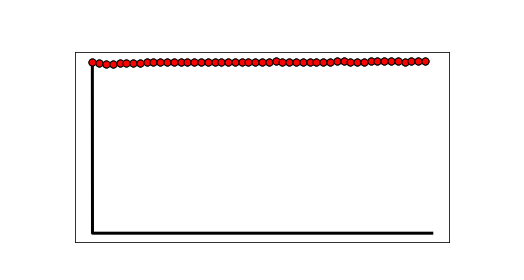

Number of data points used: 61


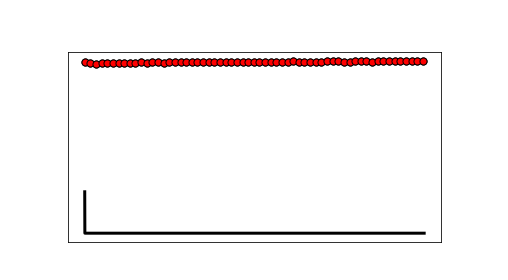

Number of data points used: 81


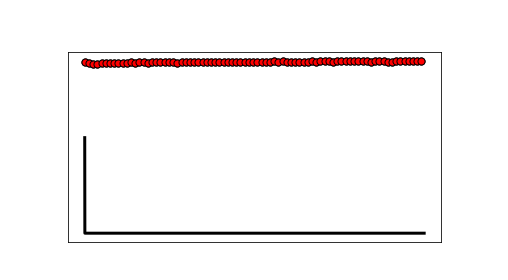

Number of data points used: 100


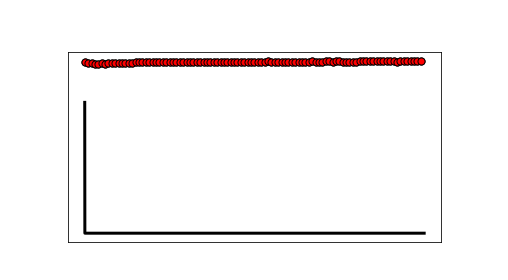

Number of data points used: 200


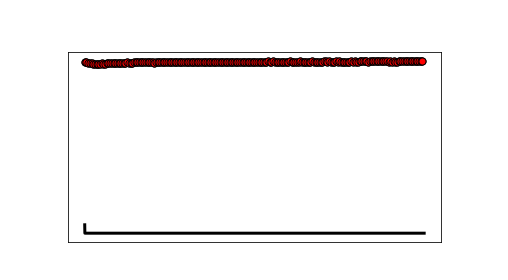

Number of data points used: 313


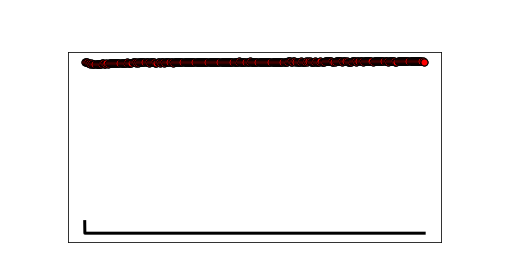

Number of data points used: 500


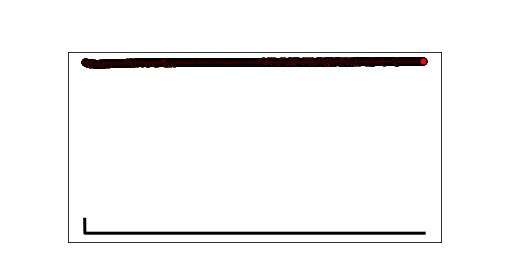

Number of data points used: 715


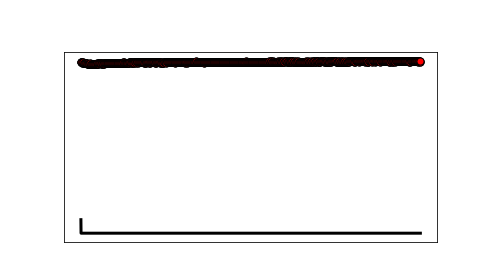

Number of data points used: 1000


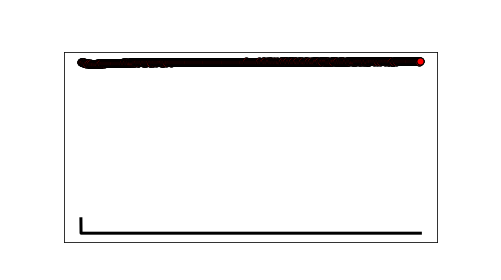

Number of data points used: 2500


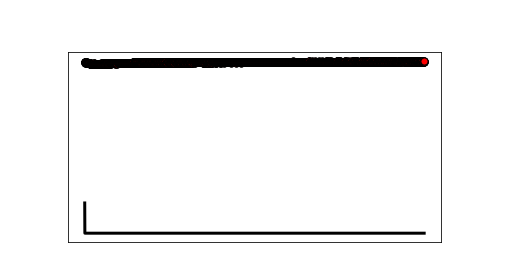


Mean squared error


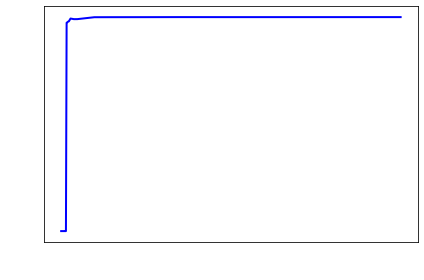

Log marginal likelihood


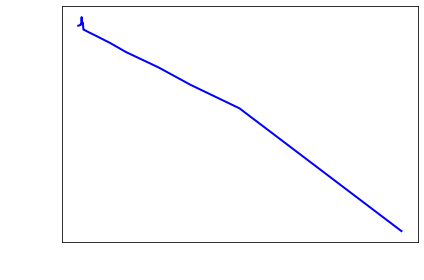

In [102]:
# Ploting how noise level would affect gp's performance

# Prepare a list of noise levels to test
# list_NOISE_LEVEL = np.array([])
# for i in range(-20,2): 
#     list_NOISE_LEVEL = np.append(list_NOISE_LEVEL,10**i)
# Set up performance parameters set
list_mse = np.array([])
list_lml = np.array([])
# Prepare data used
# NUM_OF_DATA_POINTS = 20
# Prepare noise level 
NOISE_LEVEL = 10e-12
list_DATA_POINTS = (5, 10,15,20,22,24,26,28,30,33,37,40,45,50,60,80,100,200,300,500,700,1000,2000)
for NUM_OF_DATA_POINTS in list_DATA_POINTS: 
    X = np.arange(0,5000,int(5000/NUM_OF_DATA_POINTS))
    X = X.reshape(X.size,1)
    Y = y_normal[X]
    print('Number of data points used:', X.size)

    # Kernel setting
    kernel = 1.0 * RBF(length_scale=300) + WhiteKernel(noise_level=NOISE_LEVEL, noise_level_bounds=(1e-20, 1e+1))
    gp = GaussianProcessRegressor(kernel=kernel,alpha=0).fit(X, Y)
    y_mean, y_cov = gp.predict(X_[:, np.newaxis], return_cov=True)
    plot(X_,y_normal,X,y_mean, y_cov,gp)

    # print('Noise level =',NOISE_LEVEL)

    # print ('Average absolute error:',
    # np.format_float_scientific(np.mean(np.absolute(y_normal-y_mean)),precision=5))
    # print ('Average percentage error:', np.format_float_positional(np.mean(np.absolute((y_normal-y_mean)/y_normal*100)),precision=4),'%')
    mse = mean_squared_error(Y,y_mean[X].reshape(X.size,1))
    # print ('Mean squared error:', mse)
    lml = gp.log_marginal_likelihood(gp.kernel_.theta)
    # print ('Log marginal likelihood:', log_marginal_likelihood)

    list_mse = np.append(list_mse,mse)
    list_lml = np.append(list_lml,lml)

# plot relevant graphs
print('\nMean squared error')
plot_performance(list_DATA_POINTS,list_mse)
print('Log marginal likelihood')
plot_performance(list_DATA_POINTS,list_lml)


In [83]:
print(list_NOISE_LEVEL)
print(list_mse)
print(list_lml)

[1.e-20 1.e-19 1.e-18 1.e-17 1.e-16 1.e-15 1.e-14 1.e-13 1.e-12 1.e-11
 1.e-10 1.e-09 1.e-08 1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01
 1.e+00 1.e+01]
[5.82786169e-09 5.82786169e-09 5.82786169e-09 5.82786168e-09
 1.24431555e-10 1.10984471e-10 1.10984331e-10 1.10984529e-10
 1.10985754e-10 1.11002380e-10 1.11193519e-10 1.70313068e-06
 1.70313068e-06 1.70313068e-06 1.70313068e-06 1.70313068e-06
 1.70313068e-06 1.70313068e-06 1.70313068e-06 1.76191132e-06
 3.28858076e-06 1.70313068e-06]
[-9.1791209  -9.1791209  -9.1791209  -9.17912088 28.08674504 29.53747109
 29.53747126 29.53747296 29.53748996 29.53765999 29.5393597  92.69131238
 92.69131238 92.69131238 92.69131238 92.69131238 92.69131238 92.69131238
 92.69131238 66.96466319 62.25240998 92.69131238]
